In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold,train_test_split
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

from PIL import Image
import pandas as pd 
import math

import scipy.io

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
torch.cuda.is_available()

True

In [2]:
df=pd.read_excel('C:/Users/Student/Documents/h/Video_classification.xlsx')
data_dir='C:/Users/Student/Documents/h/VideoData_trimmed'

classification = np.where(df.Classification == 'Benign' , 0, 1)
df['Class_Type'] = classification

class CEUS_Dataset(Dataset):
    def __init__ (self,df, train:bool = True):
        self.df=df
        self.train=train
        
    def __getitem__(self,index):
        
        pat_name=self.df['Pat_code'].iloc[index]
        filename=data_dir+'/'+pat_name+'.mat'
        # loading mat file
        mat = scipy.io.loadmat(filename)
        
        c=mat['xceus_red']
        #resizeing images
        x = transforms.ToTensor()(c)
        x = transforms.Resize(300)(x)
        #changing type to float
        x=x.unsqueeze(0).type(torch.FloatTensor)

        if(self.train):
            y= self.df['Class_Type'].iloc[index]
            
            return x,y
        else:
            return x
        
    def __len__(self):
        return len (self.df)
    

####dataloder

df_train, df_test = train_test_split(df)

train_dataset=CEUS_Dataset(
   df=df_train,
   train=True,
)

train_loader=DataLoader(
   train_dataset,
   batch_size=3,
   shuffle=True,
   drop_last=True,
)


test_dataset=CEUS_Dataset(
   df=df_test,
   train=True,
)

test_loader=DataLoader(
   test_dataset,
   batch_size=3,
   shuffle=False,
   drop_last=True,
)
m=len(train_dataset)

images, labels=next(iter(train_loader))
# print (images.shape)

In [3]:
class GAB_3D(nn.Module):
    def __init__(self, in_channels, g_c, i_c):
        super(GAB_3D, self).__init__()
        
        self.in_channels = in_channels
        self.g_c = g_c
        self.i_c = i_c
        
        conv = nn.Conv3d
        bn = nn.BatchNorm3d
                
        self.norm1 = lambda x: x
        
        
        self.W = nn.Sequential(
            conv(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
            bn(self.in_channels),
        )
   
        self.theta = conv(in_channels=self.in_channels, out_channels=self.i_c, kernel_size=(1,1,1), 
                          stride=(1,1,1), padding=0, bias=False)
        
        self.phi = conv(in_channels=self.g_c, out_channels=self.i_c, 
                        kernel_size=(1,1,1), stride=(1,1,1), padding=0, bias=False)
        self.psi = conv(in_channels=self.i_c, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        self.norm1 = lambda x: F.relu(x, inplace=True)
        
        self.o_f = self.joining
        
        nn.init.constant_(self.psi.bias.data, 3.0)


    def forward(self, x, g):
        
        output = self.o_f(x, g)
        return output

    def joining (self, x, g):
        x_size = x.size()
        batch_size = x_size[0]
        assert batch_size == g.size(0)

        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        phi_g = F.interpolate(self.phi(g), size=theta_x_size[2:], mode='trilinear')
        
        f = theta_x + phi_g
        f = self.norm1(f)

        psi_f = self.psi(f)
        
        sigm_psi_f = torch.sigmoid(psi_f)


        sigm_psi_f = F.interpolate(sigm_psi_f, size = x_size[2:], mode='trilinear')
        
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


class UnetConv3D(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=(1,3,3), padding_size=(0,1,1), init_stride=(1,1,1)):
        super(UnetConv3D, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv3d(in_size, out_size, kernel_size, init_stride, padding_size), 
                                   nn.ReLU(inplace=True),
                                   nn.Conv3d(out_size, out_size, kernel_size, 1, padding_size), 
                                   nn.ReLU(inplace=True),
                                   nn.BatchNorm3d(out_size), nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        return x

In [4]:
class Unet_grid_attention(nn.Module):

    def __init__(self):
        super(Unet_grid_attention, self).__init__()
        self.in_channels = 1
        
        feature = 4
        n_classes = 2
        
        

        filters = [64, 128, 256, 512]
        filters = [int(x / feature) for x in filters]
        
        
        self.conv1 = UnetConv3D(self.in_channels, filters[0])
        self.maxpool1 = nn.MaxPool3d(kernel_size=2)

        #self.conv2 = UnetConv3D(filters[0], filters[1])
        #self.maxpool2 = nn.MaxPool3d(kernel_size=2)

        self.conv3 = UnetConv3D(filters[0], filters[2])
        self.maxpool3 = nn.MaxPool3d(kernel_size=2)

        self.conv4 = UnetConv3D(filters[2], filters[3])
        self.maxpool4 = nn.MaxPool3d(kernel_size=2)

        self.conv5 = UnetConv3D(filters[3], filters[3])

        # Attention Maps
        
        
        self.c_s1 = GAB_3D(in_channels=filters[2], g_c=filters[3], i_c=filters[3])

        self.c_s2 = GAB_3D(in_channels=filters[3], g_c=filters[3], i_c=filters[3])
        
        self.relu = nn.ReLU()

        
        # Aggreagation Strategies
        
        self.att_f = [filters[2], filters[3]]

        self.classifier = nn.Linear(filters[2]+filters[3]+filters[3], n_classes)
        
        self.cluster = self.cluster_cat
        
        
        
    def cluster_cat(self, *attended_maps):
        return self.relu(self.classifier(torch.cat(attended_maps, dim=1)))


    def forward(self, x):
        # Feature Extraction
        conv1 = self.conv1(x)
        maxpool1 = self.maxpool1(conv1)

        #conv2 = self.conv2(maxpool1)
        #maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool1)
        maxpool3 = self.maxpool3(conv3)
        

        conv4 = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        conv5 = self.conv5(maxpool4)

        b_s = x.shape[0]
        pooled = F.adaptive_avg_pool3d(conv5, (1, 1, 1)).view(b_s, -1)
        

        # Attention Mechanism
        g_conv1, att1 = self.c_s1(conv3, conv5)
        
        g_conv2, att2 = self.c_s2(conv4, conv5)
        
        

        # flatten to get single feature vector
        f_s = self.att_f
        g1 = torch.sum(g_conv1.view(b_s, f_s[0], -1), dim=-1)
        
        g2 = torch.sum(g_conv2.view(b_s, f_s[1], -1), dim=-1)
        
        #print("j")
        return self.cluster(g1, g2, pooled)

    
model = Unet_grid_attention()

In [5]:
device = torch.device('cuda:0')

def train_epoch(model,dataloader,loss_fn,optimizer): 
    model=model.to(device)
    train_loss,train_correct=0.0,0
    model.train()

    for images, labels in dataloader:
        labels=labels.type(torch.LongTensor).to(device)
        images=images.to(device)
        
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output,labels)
            loss.backward()
            optimizer.step()   
            
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
        
    return train_loss, train_correct

In [6]:
def test_epoch(model,dataloader,loss_fn):
    model=model.to(device)
    test_loss, test_correct = 0.0, 0
    model.eval()
    confusion_matrix = torch.zeros(2, 2)
    for images, labels in dataloader:
        labels=labels.type(torch.LongTensor).to(device)
        images=images.to(device)
        
        with torch.set_grad_enabled(False):
            output = model(images)
            loss=loss_fn(output,labels)

            test_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        test_correct+=(predictions == labels).sum().item()
        for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

    return test_loss,test_correct,confusion_matrix

Fold Number1
Epoch:1/50 Train_Loss:5955.30 Test_Loss:3010.88 Train_Acc 66.67 % Test_Acc 88.89 %
Epoch:2/50 Train_Loss:4774.67 Test_Loss:7022.90 Train_Acc 44.44 % Test_Acc 66.67 %
Epoch:3/50 Train_Loss:1715.16 Test_Loss:75377.79 Train_Acc 55.56 % Test_Acc 11.11 %
Epoch:4/50 Train_Loss:5859.87 Test_Loss:3625.43 Train_Acc 52.78 % Test_Acc 55.56 %
Epoch:5/50 Train_Loss:744.43 Test_Loss:5342.39 Train_Acc 55.56 % Test_Acc 22.22 %
Epoch:6/50 Train_Loss:1266.41 Test_Loss:0.54 Train_Acc 47.22 % Test_Acc 33.33 %
Epoch:7/50 Train_Loss:2093.01 Test_Loss:0.69 Train_Acc 52.78 % Test_Acc 11.11 %
Epoch:8/50 Train_Loss:921.11 Test_Loss:1224.87 Train_Acc 58.33 % Test_Acc 33.33 %
Epoch:9/50 Train_Loss:1173.61 Test_Loss:3270.08 Train_Acc 55.56 % Test_Acc 77.78 %
Epoch:10/50 Train_Loss:709.08 Test_Loss:4288.11 Train_Acc 61.11 % Test_Acc 66.67 %
Epoch:11/50 Train_Loss:706.45 Test_Loss:189.84 Train_Acc 58.33 % Test_Acc 55.56 %
Epoch:12/50 Train_Loss:1171.90 Test_Loss:849.21 Train_Acc 50.00 % Test_Acc 33.33 %

Epoch:4/50 Train_Loss:1868.17 Test_Loss:21598.68 Train_Acc 50.00 % Test_Acc 44.44 %
Epoch:5/50 Train_Loss:1945.30 Test_Loss:5390.63 Train_Acc 44.44 % Test_Acc 55.56 %
Epoch:6/50 Train_Loss:2230.69 Test_Loss:0.62 Train_Acc 55.56 % Test_Acc 66.67 %
Epoch:7/50 Train_Loss:692.67 Test_Loss:0.62 Train_Acc 47.22 % Test_Acc 66.67 %
Epoch:8/50 Train_Loss:1024.37 Test_Loss:3349.24 Train_Acc 55.56 % Test_Acc 55.56 %
Epoch:9/50 Train_Loss:696.52 Test_Loss:18174.45 Train_Acc 47.22 % Test_Acc 55.56 %
Epoch:10/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:11/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:12/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:13/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:14/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:15/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:16/50 Train_Loss:0.69 Test_Loss:0.

Epoch:8/50 Train_Loss:0.58 Test_Loss:0.69 Train_Acc 52.78 % Test_Acc 55.56 %
Epoch:9/50 Train_Loss:0.64 Test_Loss:0.69 Train_Acc 44.44 % Test_Acc 55.56 %
Epoch:10/50 Train_Loss:0.67 Test_Loss:0.69 Train_Acc 38.89 % Test_Acc 55.56 %
Epoch:11/50 Train_Loss:0.67 Test_Loss:0.69 Train_Acc 38.89 % Test_Acc 55.56 %
Epoch:12/50 Train_Loss:0.64 Test_Loss:0.69 Train_Acc 44.44 % Test_Acc 55.56 %
Epoch:13/50 Train_Loss:0.65 Test_Loss:0.69 Train_Acc 41.67 % Test_Acc 55.56 %
Epoch:14/50 Train_Loss:9.27 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:15/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:16/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:17/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:18/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:19/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_Acc 55.56 %
Epoch:20/50 Train_Loss:0.69 Test_Loss:0.69 Train_Acc 36.11 % Test_

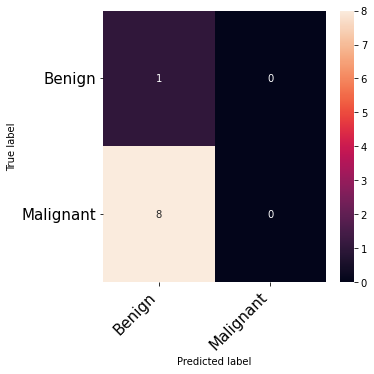

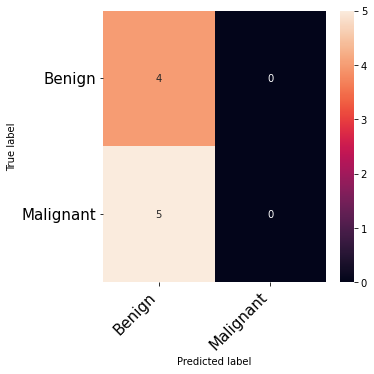

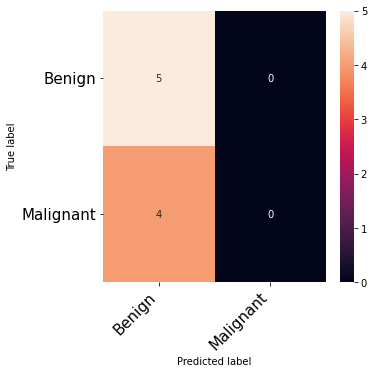

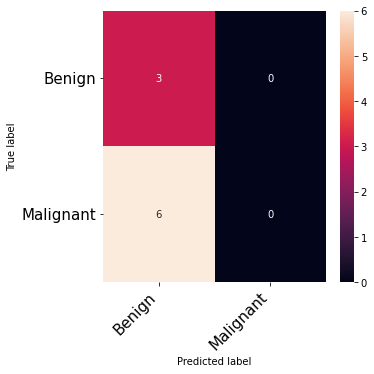

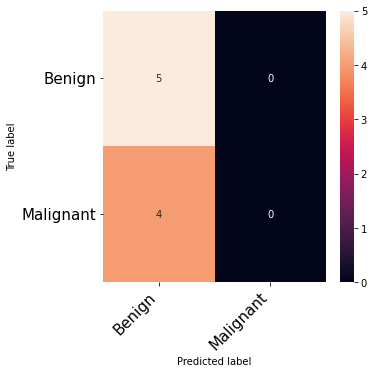

In [7]:
# Model Name = GAttCNN_r_K5F

b_s=3

device = torch.device('cuda:0')


error = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


dataset=CEUS_Dataset(df, train=True)


num_epochs=50

k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)

foldperf={}


for fold, (train_x,test_x) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold Number{}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_x)
    test_sampler = SubsetRandomSampler(test_x)
    trainLoader = torch.utils.data.DataLoader(dataset, batch_size=b_s,  sampler=train_sampler)
    testLoader = torch.utils.data.DataLoader(dataset, batch_size=b_s, sampler=test_sampler)
    
    model = Unet_grid_attention()
    
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    

    l_a = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        
        train_loss, train_correct=train_epoch(model,trainLoader,error,optimizer)
        test_loss, test_correct,e=test_epoch(model,testLoader,error)

        train_loss = train_loss / len(trainLoader.sampler)
        train_acc = train_correct / len(trainLoader.sampler) * 100
        test_loss = test_loss / len(testLoader.sampler)
        test_acc = test_correct / len(testLoader.sampler) * 100

        print("Epoch:{}/{} Train_Loss:{:.2f} Test_Loss:{:.2f} Train_Acc {:.2f} % Test_Acc {:.2f} %".format(epoch + 1, 
                                                                                                       num_epochs, 
                                                                                                       train_loss, 
                                                                                                       test_loss, 
                                                                                                       train_acc, 
                                                                                                       test_acc))
        
        #train_loss, train_correct=train_epoch(model,train_loader,error,optimizer)
        #test_loss, test_correct,e=test_epoch(model,test_loader,error)

        l_a['train_loss'].append(train_loss)
        l_a['test_loss'].append(test_loss)
        l_a['train_acc'].append(train_acc)
        l_a['test_acc'].append(test_acc)
        
    plt.figure(figsize=(5,5))    
    test_loss, test_correct,e=test_epoch(model,testLoader,error)
    df_cm = pd.DataFrame(e, index=["Benign", "Malignant"], columns=["Benign", "Malignant"]).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

    foldperf['fold{}'.format(fold+1)] = l_a

In [ ]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('{} fold cross validation'.format(k))
print("Avg Training Loss: {:.3f} \t Avg Test Loss: {:.3f} \t Avg Training Acc: {:.2f} \t Avg Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

In [9]:
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}

for i in range(num_epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_loss'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_acc'][i] for f in range(k)]))

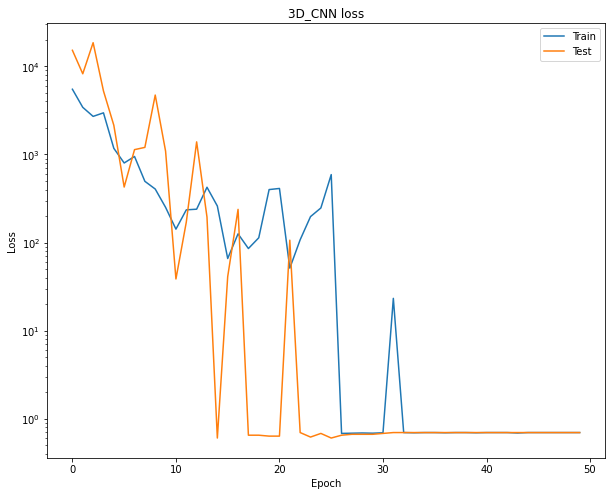

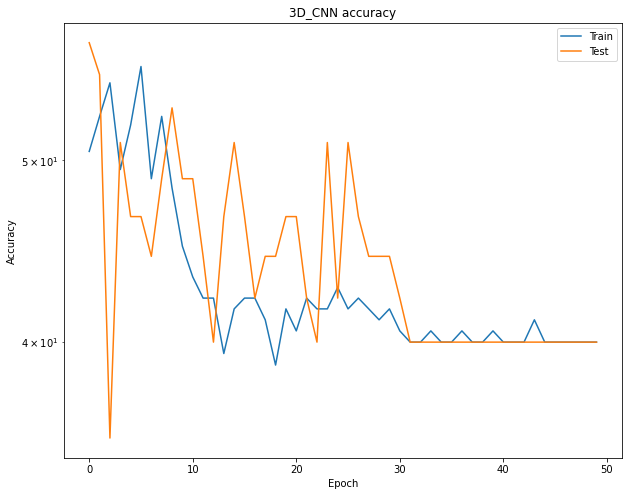

In [10]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('3D_CNN loss')
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('3D_CNN accuracy')
plt.show()

In [5]:
# Model Name = GAttCNN_r


device = torch.device('cuda:0')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


dataset = ConcatDataset([train_dataset, test_dataset])

num_epochs=250
batch_size=2

l_a = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for epoch in range(num_epochs):
    
    model=model.to(device)
    
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in train_loader:

        labels=labels.type(torch.LongTensor).to(device)
        images=images.to(device)
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output,labels)
            loss.backward()
            optimizer.step()
            
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    
    test_loss, test_correct = 0.0, 0
    model.eval() 
    for images, labels in test_loader:
        
        labels=labels.type(torch.LongTensor).to(device)
        images=images.to(device)
        
        with torch.set_grad_enabled(False):
            output = model(images)
            loss=loss_fn(output,labels)

            test_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        test_correct+=(predictions == labels).sum().item()

        

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} Train_Loss:{:.2f} Test_Loss:{:.2f} Train_Acc {:.2f} % Test_Acc {:.2f} %".format(epoch + 1, 
                                                                                                       num_epochs, 
                                                                                                       train_loss, 
                                                                                                       test_loss, 
                                                                                                       train_acc, 
                                                                                                       test_acc))
    
    
    l_a['train_loss'].append(train_loss)
    l_a['test_loss'].append(test_loss)
    l_a['train_acc'].append(train_acc)
    l_a['test_acc'].append(test_acc)

Epoch:1/250 Train_Loss:1423.23 Test_Loss:7074.45 Train_Acc 57.58 % Test_Acc 58.33 %
Epoch:2/250 Train_Loss:986.37 Test_Loss:3516.41 Train_Acc 51.52 % Test_Acc 50.00 %
Epoch:3/250 Train_Loss:777.28 Test_Loss:6464.05 Train_Acc 51.52 % Test_Acc 41.67 %
Epoch:4/250 Train_Loss:974.60 Test_Loss:4320.27 Train_Acc 57.58 % Test_Acc 50.00 %
Epoch:5/250 Train_Loss:787.24 Test_Loss:859.52 Train_Acc 63.64 % Test_Acc 50.00 %
Epoch:6/250 Train_Loss:638.24 Test_Loss:4681.39 Train_Acc 54.55 % Test_Acc 41.67 %
Epoch:7/250 Train_Loss:233.82 Test_Loss:564.33 Train_Acc 66.67 % Test_Acc 58.33 %
Epoch:8/250 Train_Loss:1137.57 Test_Loss:17378.80 Train_Acc 69.70 % Test_Acc 58.33 %
Epoch:9/250 Train_Loss:636.77 Test_Loss:13625.65 Train_Acc 63.64 % Test_Acc 50.00 %
Epoch:10/250 Train_Loss:460.10 Test_Loss:12826.98 Train_Acc 72.73 % Test_Acc 58.33 %
Epoch:11/250 Train_Loss:1015.89 Test_Loss:7456.49 Train_Acc 63.64 % Test_Acc 50.00 %
Epoch:12/250 Train_Loss:1298.16 Test_Loss:14645.34 Train_Acc 54.55 % Test_Acc 58.

Epoch:100/250 Train_Loss:0.63 Test_Loss:3127.31 Train_Acc 42.42 % Test_Acc 33.33 %
Epoch:101/250 Train_Loss:0.57 Test_Loss:3358.64 Train_Acc 51.52 % Test_Acc 25.00 %
Epoch:102/250 Train_Loss:0.61 Test_Loss:3456.87 Train_Acc 45.45 % Test_Acc 25.00 %
Epoch:103/250 Train_Loss:0.61 Test_Loss:3744.26 Train_Acc 45.45 % Test_Acc 33.33 %
Epoch:104/250 Train_Loss:0.55 Test_Loss:4102.06 Train_Acc 54.55 % Test_Acc 33.33 %
Epoch:105/250 Train_Loss:0.57 Test_Loss:3883.76 Train_Acc 48.48 % Test_Acc 33.33 %
Epoch:106/250 Train_Loss:0.55 Test_Loss:3897.92 Train_Acc 54.55 % Test_Acc 33.33 %
Epoch:107/250 Train_Loss:0.57 Test_Loss:4032.44 Train_Acc 51.52 % Test_Acc 33.33 %
Epoch:108/250 Train_Loss:0.55 Test_Loss:4245.97 Train_Acc 51.52 % Test_Acc 33.33 %
Epoch:109/250 Train_Loss:0.55 Test_Loss:3817.57 Train_Acc 54.55 % Test_Acc 33.33 %
Epoch:110/250 Train_Loss:0.57 Test_Loss:3621.43 Train_Acc 51.52 % Test_Acc 25.00 %
Epoch:111/250 Train_Loss:0.59 Test_Loss:3754.87 Train_Acc 45.45 % Test_Acc 25.00 %
Epoc

Epoch:199/250 Train_Loss:0.57 Test_Loss:4601.15 Train_Acc 51.52 % Test_Acc 41.67 %
Epoch:200/250 Train_Loss:148.29 Test_Loss:931.78 Train_Acc 39.39 % Test_Acc 50.00 %
Epoch:201/250 Train_Loss:0.63 Test_Loss:543.46 Train_Acc 42.42 % Test_Acc 50.00 %
Epoch:202/250 Train_Loss:0.65 Test_Loss:706.44 Train_Acc 39.39 % Test_Acc 50.00 %
Epoch:203/250 Train_Loss:0.65 Test_Loss:774.81 Train_Acc 39.39 % Test_Acc 50.00 %
Epoch:204/250 Train_Loss:0.67 Test_Loss:771.32 Train_Acc 36.36 % Test_Acc 50.00 %
Epoch:205/250 Train_Loss:0.67 Test_Loss:870.14 Train_Acc 36.36 % Test_Acc 50.00 %
Epoch:206/250 Train_Loss:0.69 Test_Loss:900.23 Train_Acc 33.33 % Test_Acc 50.00 %
Epoch:207/250 Train_Loss:0.63 Test_Loss:855.16 Train_Acc 42.42 % Test_Acc 50.00 %
Epoch:208/250 Train_Loss:0.63 Test_Loss:768.43 Train_Acc 42.42 % Test_Acc 50.00 %
Epoch:209/250 Train_Loss:0.65 Test_Loss:798.61 Train_Acc 39.39 % Test_Acc 50.00 %
Epoch:210/250 Train_Loss:0.69 Test_Loss:758.60 Train_Acc 33.33 % Test_Acc 50.00 %
Epoch:211/250

In [6]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]


tl_f.append(np.mean(l_a['train_loss']))
testl_f.append(np.mean(l_a['test_loss']))

ta_f.append(np.mean(l_a['train_acc']))
testa_f.append(np.mean(l_a['test_acc']))
print("Avg Training Loss: {:.3f} \t Avg Test Loss: {:.3f} \t Avg Training Acc: {:.2f} \t Avg Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

Avg Training Loss: 82.475 	 Avg Test Loss: 4111.033 	 Avg Training Acc: 49.71 	 Avg Test Acc: 36.60


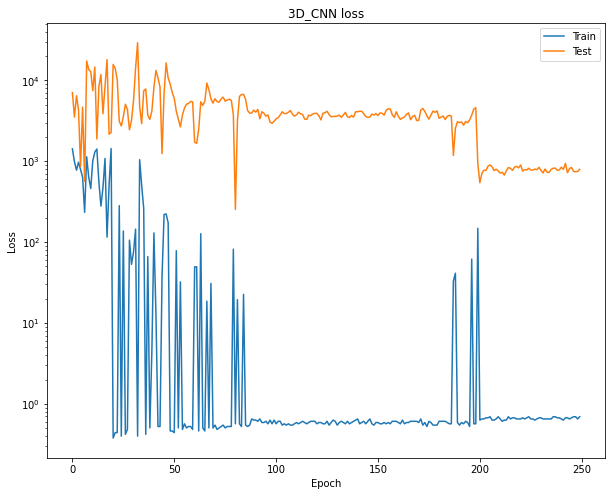

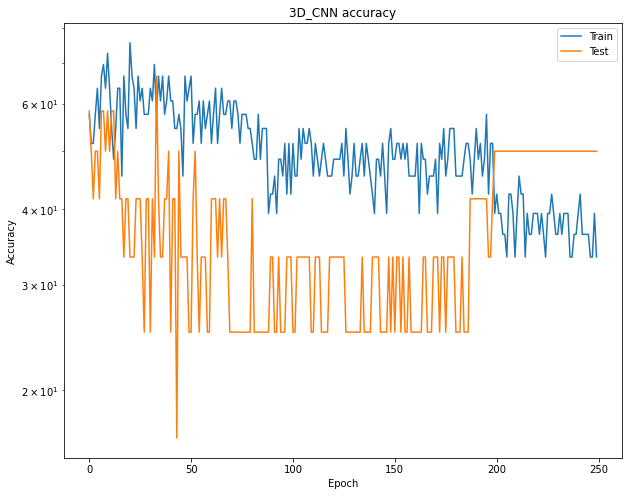

In [7]:
plt.figure(figsize=(10,8))
plt.semilogy(l_a['train_loss'], label='Train')
plt.semilogy(l_a['test_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('3D_CNN loss')
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(l_a['train_acc'], label='Train')
plt.semilogy(l_a['test_acc'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('3D_CNN accuracy')
plt.show()